In [71]:
# import packages
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
import pandas as pd
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [72]:
def load_images_from_folder(folder_path, target_size=(200, 200), color_mode='RGB'):
    images = []
    original_images = []  
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert(color_mode)  
            img_resized = img.resize(target_size)  
            images.append(np.array(img_resized).flatten())  
            original_images.append(np.array(img_resized)) 
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(original_images) 


In [73]:
def normalize_channels(images):
    n_samples, flattened_size = images.shape 
    side_length = int(np.sqrt(flattened_size // 3))  
    images_reshaped = images.reshape((n_samples, side_length, side_length, 3)) 
    
    height, width = images_reshaped.shape[1], images_reshaped.shape[2]

    r_channel = images_reshaped[..., 0]
    g_channel = images_reshaped[..., 1]
    b_channel = images_reshaped[..., 2]

    r_channel = r_channel / 255.0
    g_channel = g_channel / 255.0
    b_channel = b_channel / 255.0

    return r_channel, g_channel, b_channel, height, width


def normalize_single(images):
    # flattened_size = images.size 
    side_length = int(np.sqrt(images.size // 3))  
    images_reshaped = images.reshape((side_length, side_length, 3)) 
    
    height, width = images_reshaped.shape[1], images_reshaped.shape[1]

    r_channel = images_reshaped[..., 0]
    g_channel = images_reshaped[..., 1]
    b_channel = images_reshaped[..., 2]

    r_channel = r_channel / 255.0
    g_channel = g_channel / 255.0
    b_channel = b_channel / 255.0

    return r_channel, g_channel, b_channel, height, width

In [74]:
def perform_pca_on_channel(channel_data, n_components):
    n_samples, height, width = channel_data.shape 
    channel_flattened = channel_data.reshape((n_samples, height*width))  
    
    channel_mean = np.mean(channel_flattened, axis=0)
    channel_centered = channel_flattened - channel_mean

    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(channel_centered) 
    principal_components = pca.components_

    return Z, principal_components, channel_mean


In [75]:
def reconstruct_channel(Z, principal_components, channel_mean, height, width):
    reconstructed_flattened = np.dot(Z, principal_components) + channel_mean

    reconstructed_channel = reconstructed_flattened.reshape((-1, height, width))

    return reconstructed_channel


In [76]:
def combine_channels(r, g, b):
    reconstruct_rgb = np.stack((r, g, b), axis=1).transpose(0, 2, 3, 1)

    return reconstruct_rgb


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 199.5, 199.5, -0.5)

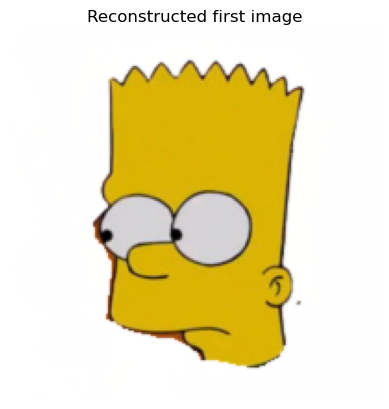

In [77]:
folder_path = "simpsons_background_removed"
simpsons_rgb, simpsons_original_rgb = load_images_from_folder(folder_path, target_size=(200, 200))

r_channel, g_channel, b_channel, height, width = normalize_channels(simpsons_rgb)

n_components = 47 #(make bigger for shaper image, but it will run slower)

r_Z, r_principal_components, r_channel_mean = perform_pca_on_channel(r_channel, n_components)
g_Z, g_principal_components, g_channel_mean = perform_pca_on_channel(g_channel, n_components)
b_Z, b_principal_components, b_channel_mean = perform_pca_on_channel(b_channel, n_components)

r_reconstructed = reconstruct_channel(r_Z, r_principal_components, r_channel_mean, height, width)
g_reconstructed = reconstruct_channel(g_Z, g_principal_components, g_channel_mean, height, width)
b_reconstructed = reconstruct_channel(b_Z, b_principal_components, b_channel_mean, height, width)

reconstructed_rgb = combine_channels(r_reconstructed, g_reconstructed, b_reconstructed)

plt.imshow(reconstructed_rgb[0])
plt.title("Reconstructed first image")
plt.axis('off')



stacked images shape: (47, 200, 200, 3)
mean array shape: (200, 200, 3)


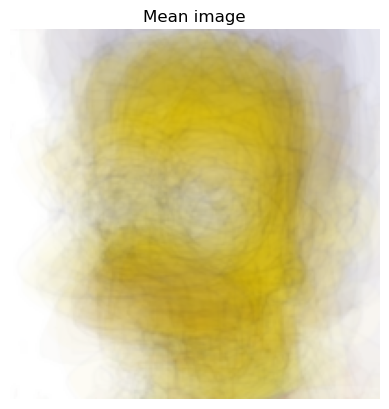

In [ ]:
# Vizualize mean simpson

# Initialize image sie
image_size = (200, 200, 3)
# Reshape image data array using image_size
reshaped_images = [image.reshape(image_size) for image in simpsons_rgb]
# Stack the images using np.stack
stacked_images = np.stack(reshaped_images)
# stacked_images shape should be (47, 200, 200, 3)
print('stacked images shape:', stacked_images.shape)

# Conmpute mean array
mean_rgb_simpson = np.mean(stacked_images, axis=0)
print('mean array shape:', mean_rgb_simpson.shape)

# Plot the mean array
plt.imshow(mean_rgb_simpson/255)
plt.title("Mean image")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 199.5, 199.5, -0.5)

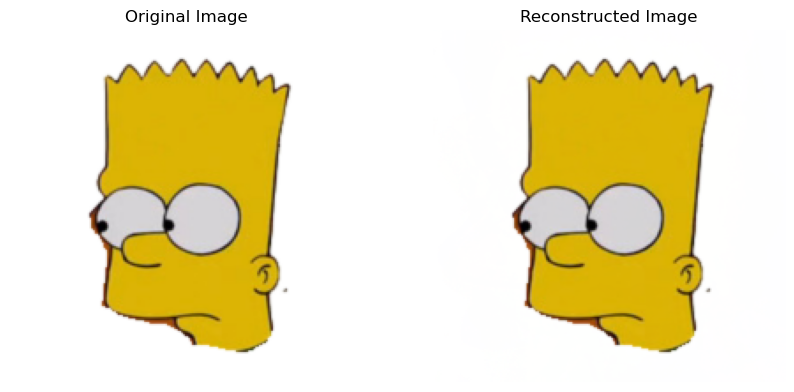

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(simpsons_original_rgb[0])
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(reconstructed_rgb[0])
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')


In [80]:
def combine_channels_for_clustering(r_Z, g_Z, b_Z, top_k):
    r_Z_top = r_Z[:, :top_k]
    g_Z_top = g_Z[:, :top_k]
    b_Z_top = b_Z[:, :top_k]
    
    combined_data = np.hstack((r_Z_top, g_Z_top, b_Z_top))
    return combined_data

top_k = 10
combined_Z = combine_channels_for_clustering(r_Z, g_Z, b_Z, top_k)
print(f"Combined PCA feature matrix shape (after top components): {combined_Z.shape}")


Combined PCA feature matrix shape (after top components): (47, 30)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


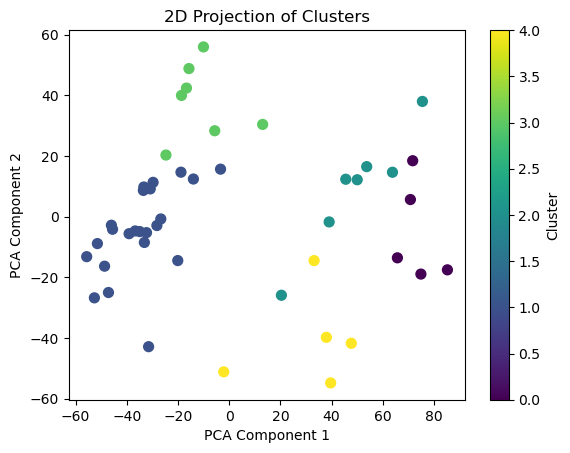

In [81]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(combined_Z)

pca_2d = PCA(n_components=3)
pca_2d_features = pca_2d.fit_transform(combined_Z)

plt.scatter(pca_2d_features[:, 0], pca_2d_features[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("2D Projection of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [82]:
from sklearn.metrics import silhouette_score
score = silhouette_score(combined_Z, clusters)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.2218841370597329


In [83]:
def plot_images_from_cluster(cluster_idx, images, labels, target_size=(200, 200)):
    cluster_images_idx = np.where(labels == cluster_idx)[0]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(cluster_images_idx[:10]):  # Show up to 10 images
        ax = plt.subplot(5, 5, i + 1)
        image_to_plot = images[idx]
        
        if image_to_plot.ndim == 1:  # Reshape if flattened
            image_to_plot = image_to_plot.reshape(target_size[0], target_size[1], 3)
        
        ax.imshow(image_to_plot)
        ax.axis('off')
    
    plt.suptitle(f"Cluster {cluster_idx + 1} Images")
    plt.show()


In [84]:
print(simpsons_original_rgb[0].shape)


(200, 200, 3)


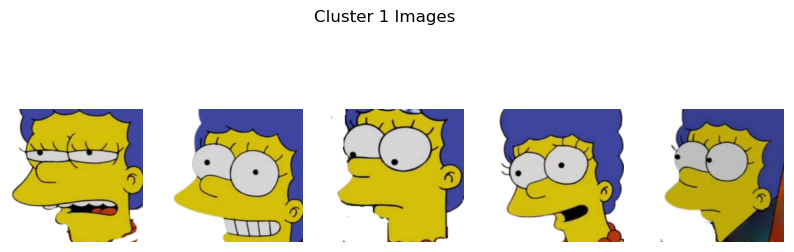

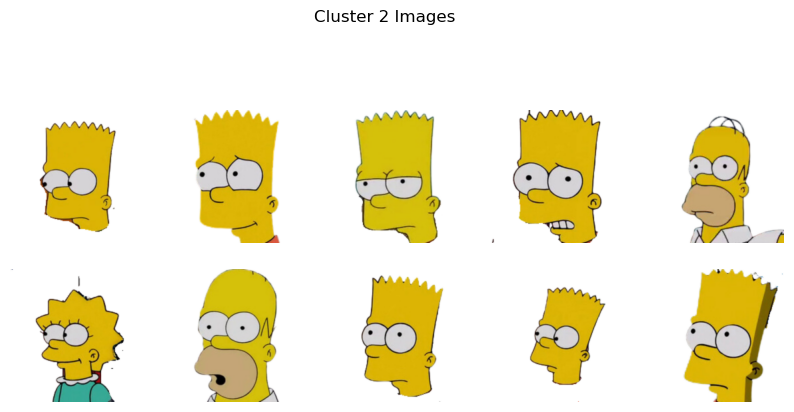

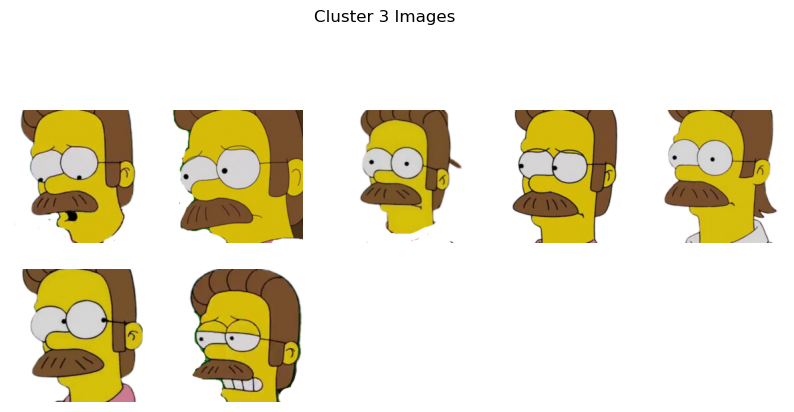

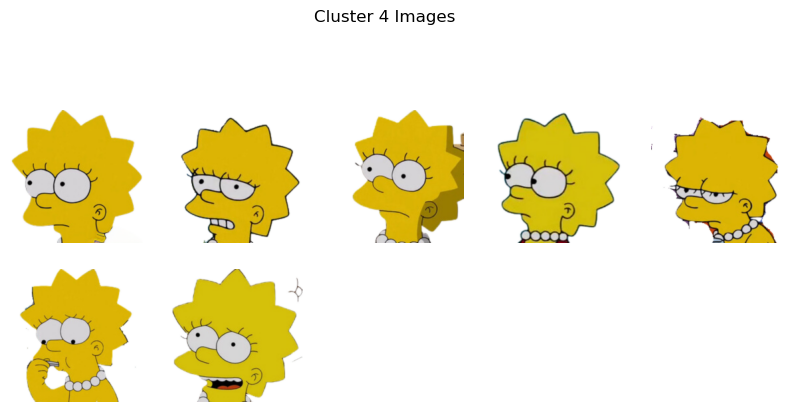

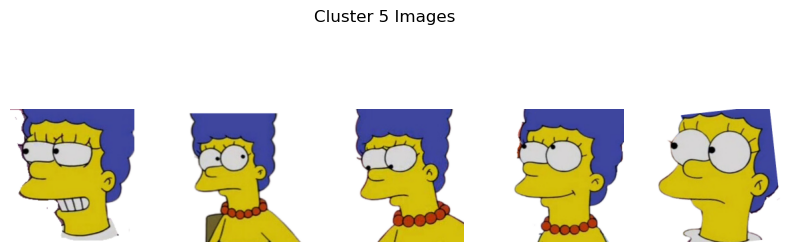

In [85]:
for cluster_idx in range(n_clusters):
    plot_images_from_cluster(cluster_idx, simpsons_rgb, clusters)


In [86]:
from sklearn.metrics import silhouette_score
score = silhouette_score(combined_Z, clusters)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.2218841370597329


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

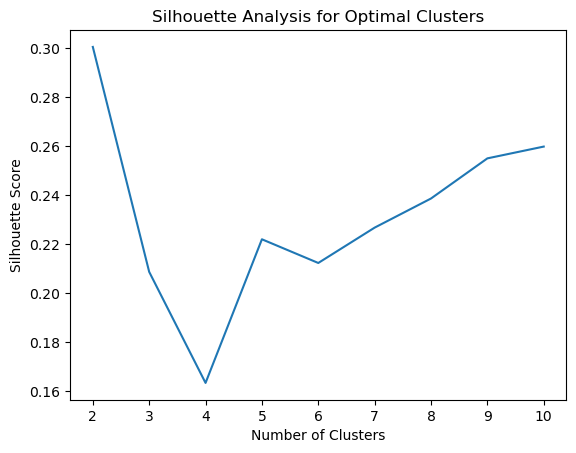

In [87]:
silhouette_scores = []
for k in range(2, 11):  # Test from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(combined_Z)
    silhouette_avg = silhouette_score(combined_Z, clusters)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores for each k
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Clusters')
plt.show()


In [88]:
def combine_channels_for_clustering(r_Z, g_Z, b_Z, top_k):
    r_Z_top = r_Z[:, :top_k]
    g_Z_top = g_Z[:, :top_k]
    b_Z_top = b_Z[:, :top_k]
    
    combined_data = np.hstack((r_Z_top, g_Z_top, b_Z_top))
    return combined_data

top_k = 14
combined_Z = combine_channels_for_clustering(r_Z, g_Z, b_Z, top_k)
print(f"Combined PCA feature matrix shape (after top components): {combined_Z.shape}")


Combined PCA feature matrix shape (after top components): (47, 42)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


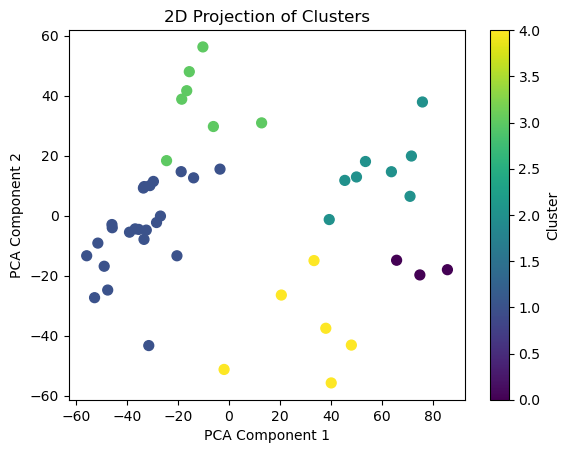

In [89]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(combined_Z)

pca_2d = PCA(n_components=5)
pca_2d_features = pca_2d.fit_transform(combined_Z)

plt.scatter(pca_2d_features[:, 0], pca_2d_features[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("2D Projection of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [90]:
def plot_images_from_cluster(cluster_idx, images, labels, target_size=(200, 200)):
    cluster_images_idx = np.where(labels == cluster_idx)[0]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(cluster_images_idx[:10]):  # Show up to 10 images
        ax = plt.subplot(5, 5, i + 1)
        image_to_plot = images[idx]
        
        if image_to_plot.ndim == 1:  # Reshape if flattened
            image_to_plot = image_to_plot.reshape(target_size[0], target_size[1], 3)
        
        ax.imshow(image_to_plot)
        ax.axis('off')
    
    plt.suptitle(f"Cluster {cluster_idx + 1} Images")
    plt.show()


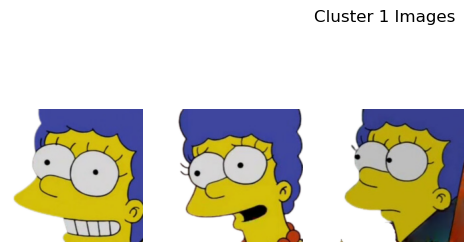

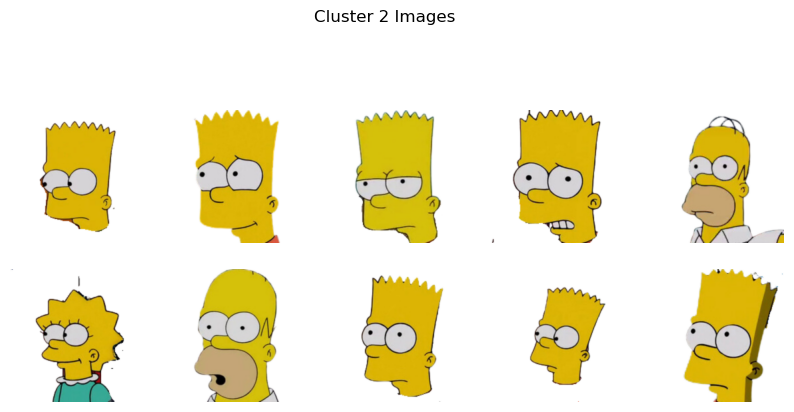

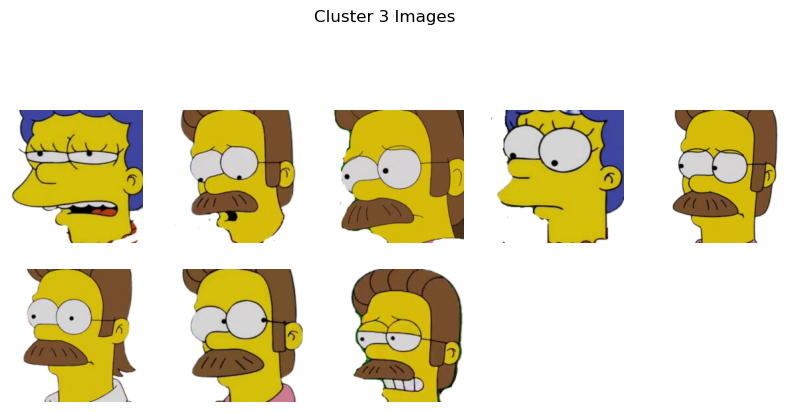

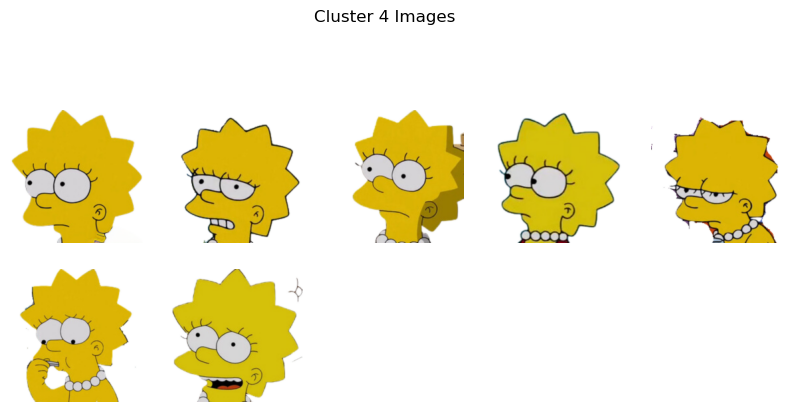

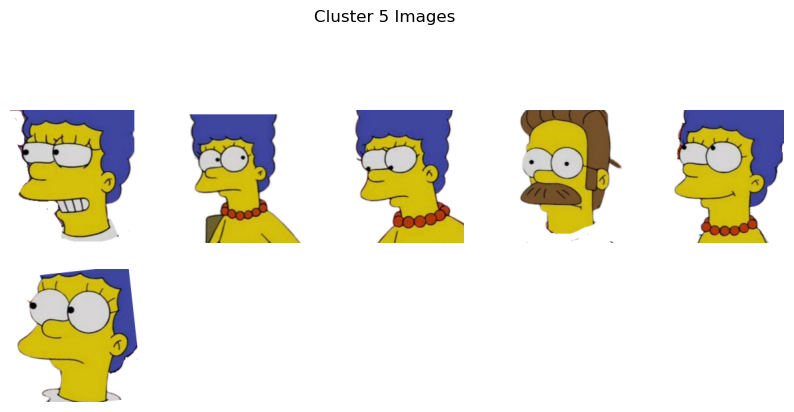

In [91]:
for cluster_idx in range(n_clusters):
    plot_images_from_cluster(cluster_idx, simpsons_rgb, clusters)


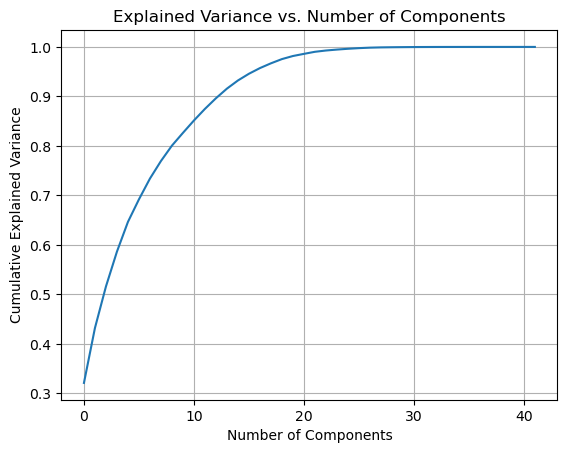

In [92]:
pca = PCA()
pca.fit(combined_Z)  # combined_Z is the data you're performing PCA on

# Plot the cumulative explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [93]:
#top_k = 8 is probably the best when we're only doing 5 clusters